In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

pd.set_option('max_colwidth', 1200)

In [ ]:
!pip install -q kaggle
!pip install transformers
!pip install wandb -qU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.2 MB/s eta 0:00:00


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
os.environ["WANDB_PROJECT"] = "Salesforce_blip_image_captioning_project"
os.environ["WANDB_LOG_MODEL"] = "true"  

In [ ]:
# img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d virajbagal/roco-dataset
!unzip roco-dataset.zip

  5% 299M/6.19G [00:15<05:18, 19.9MB/s]
User cancelled operation
Archive:  roco-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of roco-dataset.zip or
        roco-dataset.zip.zip, and cannot find roco-dataset.zip.ZIP, period.


## Create image captioning dataset

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.6 MB/s eta 0:00:00


### Train Dataset

In [ ]:
captions_train = pd.read_csv("all_data/train/radiologytraindata.csv")
# captions_train = pd.read_csv("all_data/train/radiology/captions.txt", on_bad_lines='skip', sep="\t", names=["id", "caption"])

In [ ]:
chest_x_ray_captions_train = captions_train[captions_train.caption.str.contains("chest x-ray", case=False, na=False)]
chest_x_ray_captions_train = chest_x_ray_captions_train.drop("id", axis=1)

chest_x_ray_captions_train.rename(columns = {'name':'file_name', 'caption':'text'}, inplace = True)
len(chest_x_ray_captions_train)

1735

In [ ]:
# chest_x_ray_captions_train.to_csv('all_data/train/metadata.csv', index=False, encoding='utf-8')

In [ ]:
metadata_df = chest_x_ray_captions_train.copy()
captions = []
for index, row in chest_x_ray_captions_train.iterrows():
  captions.append({"file_name": row["file_name"], "text": row["text"]})

In [ ]:
import json

# path to the folder containing the images
root = "/content/all_data/train/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

In [ ]:
# Copy train images under the train folder

import shutil

for index, row in chest_x_ray_captions_train.iterrows():
  colab_link = "/content/all_data/train/radiology/images/" + row['file_name']
  gdrive_link = "/content/all_data/train"
  shutil.copy(colab_link, gdrive_link)


### Test Dataset

In [ ]:
captions_test = pd.read_csv("all_data/test/radiologytestdata.csv")
chest_x_ray_captions_test = captions_test[captions_test.caption.str.contains("chest x-ray", case=False, na=False)]
chest_x_ray_captions_test = chest_x_ray_captions_test.drop("id", axis=1)

chest_x_ray_captions_test.rename(columns = {'name':'file_name', 'caption':'text'}, inplace = True)
len(chest_x_ray_captions_test)

199

In [ ]:
metadata_test_df = chest_x_ray_captions_test.copy()
captions_test = []
for index, row in metadata_test_df.iterrows():
  captions_test.append({"file_name": row["file_name"], "text": row["text"]})

In [ ]:
import json

# path to the folder containing the images
root = "/content/all_data/test/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions_test:
        f.write(json.dumps(item) + "\n")

In [ ]:
# Copy test images under the test folder

import shutil

for index, row in chest_x_ray_captions_test.iterrows():
  colab_link = "/content/all_data/test/radiology/images/" + row['file_name']
  gdrive_link = "/content/all_data/test"
  shutil.copy(colab_link, gdrive_link)

### Validation Dataset

In [ ]:
captions_val = pd.read_csv("all_data/validation/radiologyvaldata.csv")
chest_x_ray_captions_val = captions_val[captions_val.caption.str.contains("chest x-ray", case=False, na=False)]
chest_x_ray_captions_val = chest_x_ray_captions_val.drop("id", axis=1)

chest_x_ray_captions_val.rename(columns = {'name':'file_name', 'caption':'text'}, inplace = True)
len(chest_x_ray_captions_val)

222

In [ ]:
metadata_val_df = chest_x_ray_captions_val.copy()
captions_val = []
for index, row in metadata_val_df.iterrows():
  captions_val.append({"file_name": row["file_name"], "text": row["text"]})

In [ ]:
import json

# path to the folder containing the images
root = "/content/all_data/validation/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions_val:
        f.write(json.dumps(item) + "\n")

In [ ]:
# Copy validation images under the validation folder

import shutil

for index, row in chest_x_ray_captions_val.iterrows():
  colab_link = "/content/all_data/validation/radiology/images/" + row['file_name']
  gdrive_link = "/content/all_data/validation"
  shutil.copy(colab_link, gdrive_link)

In [ ]:
!rm -rf "/content/all_data/train/non-radiology/"
!rm -rf "/content/all_data/train/radiology/"

!rm -rf "/content/all_data/test/non-radiology/"
!rm -rf "/content/all_data/test/radiology/"

!rm -rf "/content/all_data/validation/non-radiology/"
!rm -rf "/content/all_data/validation/radiology/"

In [ ]:
from datasets import load_dataset 
root = "all_data/"
dataset = load_dataset("imagefolder", data_dir=root, split="train")
dataset_validation = load_dataset("imagefolder", data_dir=root, split="validation")

Resolving data files:   0%|          | 0/1737 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/201 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-25e8ed5268d4829a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/1737 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/201 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1735
})

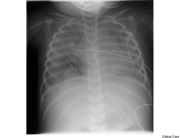

In [ ]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

## Create PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

## Load model and processor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
loss = torch.nn.BCELoss(size_average=True)

criterion = torch.nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else torch.nn.CrossEntropyLoss()

In [ ]:
import requests
# from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoProcessor

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

In [ ]:
def train(model, device, train_dataloader, optimizer, epoch):
  losses = 0
  model.train()

  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    
    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    # loss = F.nll_loss(outputs, pixel_values) # nll is the negative likelihood loss
    
    loss = outputs.loss
    losses += loss.item()

    print("Loss:", loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if idx % 10 == 0:
      wandb.log({"loss": loss})
      print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
          epoch, idx * len(input_ids), 
          len(train_dataloader.dataset),
          100. * idx / len(train_dataloader), 
          loss.item()))
  print(f'Cost at epoch {epoch} is {sum(losses/len(losses))}')

In [ ]:
def evaluate(model, device, test_dataloader):
  loss = 0
  success = 0

  num_correct = 0
  num_samples = 0
  total_loss = 0

  losstensorMean = 0


  # Tracking variables
  val_accuracy = []
  val_loss = []
  f1_weighted = []

  result = []
  model.eval()
  with torch.no_grad():
    for batch in test_dataloader:

      # input_ids, pixel_values = input_ids.to(device), pixel_values.to(device)
      input_ids = batch.pop("input_ids").to(device)
      # batch.pop("input_ids").type(torch.FloatTensor).to(device)
      pixel_values = batch.pop("pixel_values").to(device)

      """
      captions = model.generate(pixel_values, num_beams=3, 
                                max_length=20, 
                                min_length=5)
        
      for caption, img_id in zip(captions, input_ids):
          result.append({"image_id": img_id.item(), "caption": caption})
      """

      outputs = model(input_ids=input_ids,
           pixel_values=pixel_values,
           labels=input_ids)
      
      logits = outputs[0]


      val_loss.append(outputs.loss.item())

      # Calculate the accuracy rate
      #accuracy = (predictions == input_ids).cpu().numpy().mean() * 100
      #val_accuracy.append(accuracy)


      #print(val_accuracy)

      # print(type(pixel_values))

      # losstensor = loss(outputs, pixel_values)
      # losstensorMean += losstensor
        
      # lossVal += losstensor.item()
      # lossValNorm += 1

      #total_loss += outputs.loss.item()
    #print("Total loss", total_loss)

    # outLoss = lossVal / lossValNorm
    # losstensorMean = losstensorMean / lossValNorm

    # return outLoss, losstensorMean
      
      #itm_score = torch.nn.functional.softmax(pred_prob, dim=1)[:, 1]
      
      #print(itm_score)

      #_, predictions = pred_prob.max(1)
      num_correct += (logits == input_ids).sum()
      num_samples += logits.size(0)

    #print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
      
      # loss = pred_prob.loss
      # pred_prob = model(input_ids)

      # loss += F.nll_loss(pred_prob, pixel_values, reduction='sum').item() # loss summed across the batch
      
      # logits_per_image = pred_prob.logits_per_image
      # probs = logits_per_image.softmax(dim=1)
  

      # pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
      # success += pred.eq(pixel_values.view_as(pred)).sum().item()
  # loss /= len(test_dataloader.dataset)
  # print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
  #    loss, success, len(test_dataloader.dataset),
  #    100. * success / len(test_dataloader.dataset)))


In [ ]:
args = {
        "learning_rate": 5e-5,
        "epochs": 2,
        "batch_size": 16   
    }
wandb.init(project="Salesforce_blip_image_captioning_project",
config = args)

wandb: Currently logged in as: bertan-ulusoy. Use `wandb login --relogin` to force relogin


In [ ]:
import torch

# Wandb
num_epochs = wandb.config["epochs"]
learning_rate = wandb.config["learning_rate"]
wandb.watch(model, log="all", log_freq=10)


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

val_dataset = ImageCaptioningDataset(dataset_validation, processor)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=2)

In [ ]:
val_dataset.dataset

In [ ]:
for epoch in range(1, 3):
  # train(model, device, train_dataloader, optimizer, epoch)
  evaluate(model, device, val_dataloader)

ValueError: ignored

In [ ]:
 #model_save_name = 'salesforce_blip_image_captioning.pt'
  #path = f"/content/gdrive/MyDrive/NioyatechTask/models/{model_save_name}"
  #model.save_pretrained() 
  #torch.save(model.state_dict(), path)
  #load_state_dict(torch.load(path))

In [ ]:
"""
model.train()
total_loss = 0

for epoch in range(num_epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss
    # total_loss += loss

    print("Loss:", loss.item())
    # print("Total Loss:", total_loss)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if idx:
        wandb.log({"loss": loss})

# torch.save(model.state_dict(), "/content/all_data/models")
"""

In [ ]:
#training_args = TrainingArguments("test-trainer")

In [ ]:
"""
trainer = Trainer(
    model,
    training_args,
    train_dataset=dataset,
    eval_dataset=dataset_validation
)
"""